# Multiple changepoint detection and Bayesian model selection


In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Imports

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

##  Task: changepoint detection with multiple changepoints

Consider a changepoint detection task:  events happen at a rate that changes over time, driven by sudden shifts in the (unobserved) state of some system or process generating the data.

For example, we might observe a series of counts like the following:

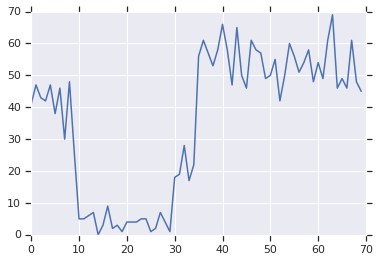

In [0]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

observed_counts = np.concatenate([
  scipy.stats.poisson(rate).rvs(num_steps)
    for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)

plt.plot(observed_counts)

These could represent the number of failures in a datacenter, number of visitors to a webpage, number of packets on a network link, etc.

Note it's not entirely apparent how many distinct system regimes there are just from looking at the data. Can you tell where each of the three switchpoints occurs?

## Known number of states

We'll first consider the (perhaps unrealistic) case where the number of unobserved states is known a priori. Here, we'd assume we know there are four latent states.

We model this problem as a switching (inhomogeneous) Poisson process: at each point in time, the number of events that occur is Poisson distributed, and the *rate* of events is determined by the unobserved system state $z_t$:

$$x_t \sim \text{Poisson}(\lambda_{z_t})$$

The latent states are discrete: $z_t \in \{1, 2, 3, 4\}$, so $\lambda = [\lambda_1, \lambda_2, \lambda_3, \lambda_4]$ is a simple vector containing a Poisson rate for each state. To model the evolution of states over time, we'll define a simple transition model $p(z_t | z_{t-1})$: let's say that at each step we stay in the previous state with some probability $p$, and with probability $1-p$ we transition to a different state uniformly at random. The initial state is also chosen uniformly at random, so we have:

$$
\begin{align*}
z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\
z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right)
\end{align*}$$

These assumptions correspond to a [hidden Markov model](http://mlg.eng.cam.ac.uk/zoubin/papers/ijprai.pdf) with Poisson emissions. We can encode them in TFP using `tfd.HiddenMarkovModel`. First, we define the transition matrix and the uniform prior on the initial state:

In [0]:
num_states = 4

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[ 0.  0.  0.  0.]
Transition matrix:
[[ 0.94999999  0.01666667  0.01666667  0.01666667]
 [ 0.01666667  0.94999999  0.01666667  0.01666667]
 [ 0.01666667  0.01666667  0.94999999  0.01666667]
 [ 0.01666667  0.01666667  0.01666667  0.94999999]]


Next, we build a `tfd.HiddenMarkovModel` distribution, using a trainable variable to represent the rates associated with each system state. We parameterize the rates in log-space to ensure they are positive-valued.

In [0]:
tf.reset_default_graph()

# Define variable to represent the unknown log rates.
trainable_rates = tf.exp(tf.get_variable(
    'log_rates', initializer=(
        np.log(np.mean(observed_counts)) + tf.random_normal([num_states]))))

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(trainable_rates),
  num_steps=len(observed_counts))

Finally, we define the model's total log density, including a weakly-informative LogNormal prior on the rates, and run an optimizer to compute the [maximum a posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) fit to the observed count data.

In [0]:
rate_prior = tfd.LogNormal(5, 5)
total_log_prob = (
    tf.reduce_sum(rate_prior.log_prob(trainable_rates)) +
    hmm.log_prob(observed_counts))

train_op = tf.train.AdamOptimizer(0.1).minimize(-total_log_prob)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(201):
  _, loss_, rates_ = sess.run((train_op, total_log_prob, trainable_rates))

  if step % 20 == 0:
    print("step {}: log prob {} rates {}".format(step, loss_, rates_))

print("Inferred rates: {}".format(rates_))
print("True rates: {}".format(true_rates))


step 0: log prob -656.555480957 rates [  73.95337677   28.91309357  115.55673218   25.37959099]
step 20: log prob -275.879882812 rates [ 33.17310715  76.04164886  52.57240295   5.49490452]
step 40: log prob -261.123962402 rates [ 22.35352135  81.7260437   51.71455383   3.3429575 ]
step 60: log prob -260.758117676 rates [ 20.29379463  77.85356903  51.83719635   3.51979518]
step 80: log prob -260.13458252 rates [ 21.70909691  71.68695831  51.71755219   3.8770504 ]
step 100: log prob -258.179626465 rates [ 21.58044052  59.14146042  50.63894653   3.90205407]
step 120: log prob -248.42401123 rates [ 20.82899475  54.13412857  41.92335129   3.85124207]
step 140: log prob -248.51461792 rates [ 20.76467514  53.67557526  40.03132248   3.85271001]
step 160: log prob -248.346206665 rates [ 20.84091568  54.12538147  41.20120239   3.85899258]
step 180: log prob -248.344451904 rates [ 20.80753136  54.14757919  41.08810806   3.85737729]
step 200: log prob -248.343658447 rates [ 20.81398201  54.1206436

It worked! Note that the latent states in this model are identifiable only up to permutation, so the rates we recovered are in a different order, and there's a bit of noise, but generally they match pretty well.

### Recovering the state trajectory

Now that we've fit the model, we might want to reconstruct *which* state the model believes the system was in at each timestep.

This is a *posterior inference* task: given the observed counts $x_{1:T}$ and model parameters (rates) $\lambda$, we want to infer the sequence of discrete latent variables, following the posterior distribution $p(z_{1:T} | x_{1:T}, \lambda)$. In a hidden Markov model, we can efficiently compute marginals and other properties of this distribution using standard message-passing algorithms. In particular, the `posterior_marginals` method will efficiently compute (using the [forward-backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm)) the marginal probability distribution $p(Z_t = z_t | x_{1:T})$ over the discrete latent state $Z_t$ at each timestep $t$.

In [0]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs_ = sess.run(posterior_dists.probs)  # extract the probabilities.

In [0]:
sess.close()

Plotting the posterior probabilities, we recover the model's "explanation" of the data: at which points in time is each state active?

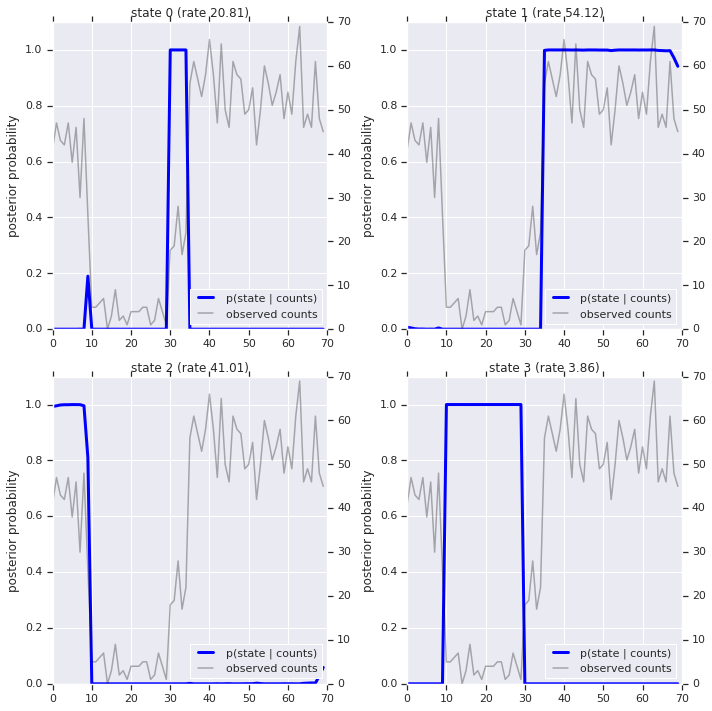

In [0]:
def plot_state_posterior(ax, state_posterior_probs, title):
  ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
  ax.set_ylim(0., 1.1)
  ax.set_ylabel('posterior probability')
  ax2 = ax.twinx()
  ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax2.set_title(title)
  ax2.set_xlabel("time")
  lns = ln1+ln2
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=4)
  ax.grid(True, color='white')
  ax2.grid(False)

fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs_[:, 0],
                     title="state 0 (rate {:.2f})".format(rates_[0]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs_[:, 1],
                     title="state 1 (rate {:.2f})".format(rates_[1]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs_[:, 2],
                     title="state 2 (rate {:.2f})".format(rates_[2]))
plot_state_posterior(fig.add_subplot(2, 2, 4),
                     posterior_probs_[:, 3],
                     title="state 3 (rate {:.2f})".format(rates_[3]))
plt.tight_layout()

In this (simple) case, we see that the model is usually quite confident: at most timesteps it assigns essentially all probability mass to a single one of the four states. Luckily, the explanations look reasonable!

We can also visualize this posterior in terms of the rate associated with the *most likely* latent state at each timestep, condensing the probabilistic posterior into a single explanation:

In [0]:
most_probable_states = np.argmax(posterior_probs_, axis=1)
most_probable_rates = rates_[most_probable_states]

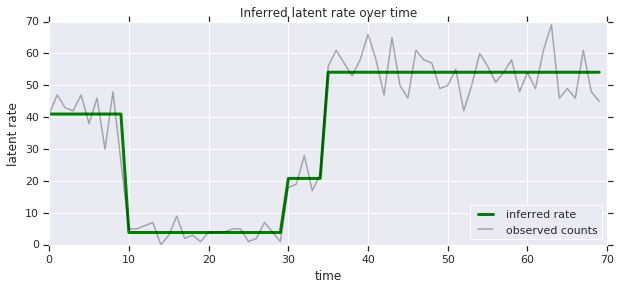

In [0]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred rate')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4)

Technical note: instead of the most probable state at each individual timestep, $z^*_t = \text{argmax}_{z_t} p(z_t | x_{1:T})$, we could have asked for the most probable latent *trajectory*, $z^* = \text{argmax}_z p(z | x_{1:T})$ (or even samples from the posterior over trajectories!), taking dependence between timesteps into account. To illustrate the difference, suppose a rock-paper-scissors player plays rock 40% of the time, but never twice in a row: rock may be the most likely marginal state at every point in time, but "rock, rock, rock...'' is definitely *not* the most likely trajectory -- in fact, it has zero probability!

TODO(davmre): once `tfp.HiddenMarkovModel` implements the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) to find highest-probability trajectories, update this section to use it.

## Unknown number of states

In real problems, we may not know the 'true' number of states in the system we're modeling. This may not always be a concern: if you don't particularly care about the identities of the unknown states, you could just run a model with more states than you know the model will need, and learn (something like) a bunch of duplicate copies of the actual states. But let's assume you do care about inferring the 'true' number of latent states.

We can view this as a case of [Bayesian model selection](http://alumni.media.mit.edu/~tpminka/statlearn/demo/): we have a set of candidate models, each with a different number of latent states, and we want to choose the one that is most likely to have generated the observed data. To do this, we compute the marginal likelihood of the data under each model (we could also add a prior on the models themselves, but that won't be necessary in this analysis; the [Bayesian Occam's razor](https://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/MacKay2003-Ch28.pdf) turns out to be sufficient to encode a preference towards simpler models).

Unfortunately, the true marginal likelihood, which integrates over both the discrete states $z_{1:T}$ and the (vector of) rate parameters $\lambda$, $$p(x_{1:T}) = \int p(x_{1:T}, z_{1:T}, \lambda) dz d\lambda,$$ is not tractable for this model. For convenience, we'll approximate it using a so-called "[empirical Bayes](https://www.cs.ubc.ca/~schmidtm/Courses/540-W16/L19.pdf)" or "type II maximum likelihood" estimate: instead of fully integrating out the (unknown) rate parameters $\lambda$ associated with each system state, we'll optimize over their values:

$$\tilde{p}(x_{1:T}) = \max_\lambda \int p(x_{1:T}, z_{1:T}, \lambda) dz$$

This approximation may overfit, i.e., it will prefer more complex models than the true marginal likelihood would. We could consider more faithful approximations, e.g., optimizing a variational lower bound, or using a Monte Carlo estimator such as [annealed importance sampling](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/sample_annealed_importance_chain); these are (sadly) beyond the scope of this notebook. (For more on Bayesian model selection and approximations, chapter 7 of the excellent [Machine Learning: a Probabilistic Perspective
](https://www.cs.ubc.ca/~murphyk/MLbook/) is a good reference.)

In principle, we could do this model comparison simply by rerunning the optimization above many times with different values of `num_states`, but that would be a lot of work. Here we'll show how to consider multiple models in parallel, using TFP's `batch_shape` mechanism for vectorization.

**Transition matrix and initial state prior**: rather than building a single model description, now we'll build a *batch* of transition matrices and prior logits, one for each candidate model up to `max_num_states`. For easy batching we'll need to ensure that all computations have the same 'shape': this must correspond to the dimensions of the largest model we'll fit. To handle smaller models, we can  'embed' their descriptions in the topmost dimensions of the state space, effectively treating the remaining dimensions as dummy states that are never used.

In [0]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
  initial_state_logits[:num_states] = 0.

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = np.eye(max_num_states, dtype=np.float32)
  if num_states > 1:
    transition_probs[:num_states, :num_states] = (
        daily_change_prob / (num_states-1))
    np.fill_diagonal(transition_probs[:num_states, :num_states],
                     1-daily_change_prob)
  return initial_state_logits, transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (10, 10)
Shape of transition probs: (10, 10, 10)
Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100. -100. -100. -100. -100.]
Example transition_probs for num_states==3:
[[ 0.94999999  0.025       0.025       0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.025       0.94999999  0.025       0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.025       0.025       0.94999999  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

Now we proceed similarly as above. This time we'll use an extra batch dimension in `trainable_rates` to separately fit the rates for each model under consideration.

In [0]:
tf.reset_default_graph()

trainable_rates = tf.exp(tf.get_variable(
    'log_rates',
    initializer=(
        np.log(np.mean(observed_counts)) *
        np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
        tf.random_normal([1, max_num_states]))))

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(trainable_rates),
  num_steps=len(observed_counts))

In computing the total log prob, we are careful to sum over only the priors for the rates actually used by each model component:


In [0]:
rate_prior = tfd.LogNormal(5, 5)

prior_lps = rate_prior.log_prob(trainable_rates)
prior_lp = tf.stack([
    tf.reduce_sum(prior_lps[i, :i+1])
    for i in range(max_num_states)])

In [0]:
total_log_prob = (
    prior_lp +
    hmm.log_prob(observed_counts))

train_op = tf.train.AdamOptimizer(0.1).minimize(-total_log_prob)

Now we optimize the *batch* objective we've constructed, fitting all candidate models simultaneously:

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(201):
  _, total_log_prob_ = sess.run((train_op, total_log_prob))

  total_log_prob_ = sess.run((total_log_prob))
  if step % 20 == 0:
    print("step {}: log probs {}".format(step, total_log_prob_))

learned_rates_ = sess.run(trainable_rates)

step 0: log probs [-944.81622314 -951.96899414 -311.06134033 -290.16409302 -297.9737854
 -296.89675903 -297.65429688 -303.55670166 -308.96862793 -315.28204346]
step 20: log probs [-865.35925293 -346.33798218 -254.09133911 -252.77212524 -258.06970215
 -265.33407593 -270.79260254 -276.39294434 -279.54763794 -284.41073608]
step 40: log probs [-843.74700928 -300.53594971 -252.47946167 -248.60549927 -255.34309387
 -261.86502075 -267.58944702 -273.53823853 -277.72042847 -282.41430664]
step 60: log probs [-843.8303833  -297.07070923 -251.62112427 -248.37060547 -254.37657166
 -261.41439819 -267.38128662 -273.18225098 -277.34545898 -281.02520752]
step 80: log probs [-843.47076416 -296.8565979  -251.4430542  -248.34793091 -254.26861572
 -261.33291626 -267.31582642 -273.15090942 -277.22296143 -280.6852417 ]
step 100: log probs [-843.45892334 -296.71670532 -251.42454529 -248.34436035 -254.25704956
 -261.32034302 -267.30819702 -273.14572144 -277.128479   -280.58456421]
step 120: log probs [-843.458

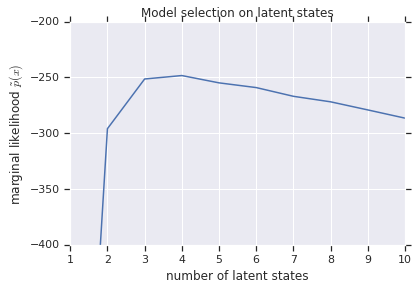

In [0]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, total_log_prob_)
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

Examining the likelihoods, we see that the (approximate) marginal likelihood prefers a three- or four-state model (the specific ordering may vary between runs of this notebook). This seems quite plausible -- the 'true' model had four states, but from just looking at the data it's hard to rule out a three-state explanation.


We can also extract the rates fit for each candidate model:

In [0]:
for i, learned_model_rates_ in enumerate(learned_rates_):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates_[:i+1]))

rates for 1-state model: [ 35.47252655]
rates for 2-state model: [ 49.80340958   5.5464735 ]
rates for 3-state model: [ 51.70901871  21.54446411   3.85725999]
rates for 4-state model: [ 54.10387039  41.0456543    3.85735941  20.81387329]
rates for 5-state model: [ 20.70896912  41.14213943   3.85735488  20.7090435   54.099823  ]
rates for 6-state model: [ 40.84007645  54.07774353   3.8573699   20.73516846  54.07864761
  40.84005737]
rates for 7-state model: [ 54.03517532  20.62760925   3.85736728  20.62771606  54.03516388
  41.00030136  54.03511047]
rates for 8-state model: [ 54.03466034  20.49001694   3.85736227  20.48946953  54.03440094
  41.05328751  54.03466034  20.48965836]
rates for 9-state model: [ 54.03406525  20.4622879    0.77144349  20.46162796  54.03421021
  41.01068115  54.03433609  20.4616375    3.86175203]
rates for 10-state model: [ 40.89097595  20.43305016   0.76783544  20.43265152  54.06986618
  40.890625    54.06981659   3.8186841    3.81822777  20.43225288]


And plot the explanations each model provides for the data:

In [0]:
posterior_probs_ = sess.run(hmm.posterior_marginals(observed_counts).probs)
most_probable_states = np.argmax(posterior_probs_, axis=-1)
sess.close()

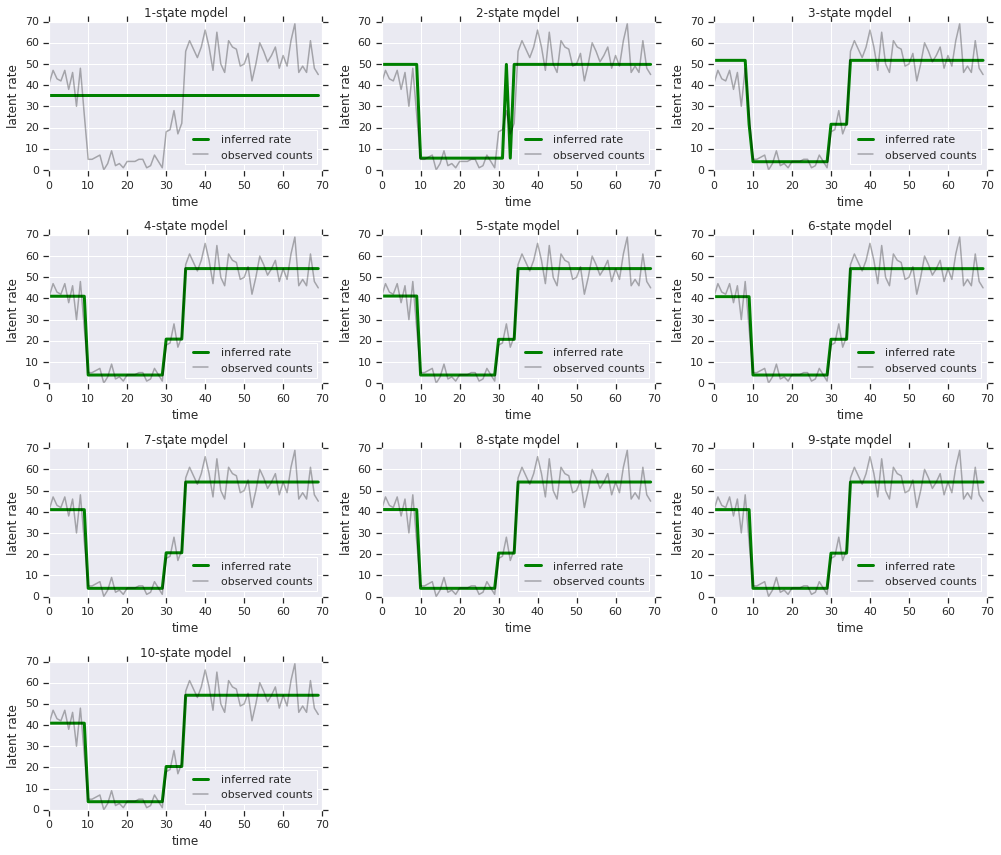

In [0]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates_ in enumerate(learned_rates_):
  ax = fig.add_subplot(4, 3, i+1)
  ax.plot(learned_model_rates_[most_probable_states[i]], c='green', lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title("{}-state model".format(i+1))
  ax.legend(loc=4)
plt.tight_layout()

It's easy to see how the one-, two-, and (more subtly) three-state models provide inadequate explanations. Interestingly, all models above four states provide essentially the same explanation! This is likely because our 'data' is relatively clean and leaves little room for alternative explanations; on messier real-world data we would expect the higher-capacity models to provide progressively better fits to the data, with some tradeoff point where the improved fit is outweighted by model complexity.

### Extensions

The models in this notebook could be straightforwardly extended in many ways. For example:

- allowing latent states to have different probabilities (some states may be common vs rare)
- allowing nonuniform transitions between latent states (e.g., to learn that a machine crash is usually followed by a system reboot is usually followed by a period of good performance, etc.)
- other emission models, e.g. `NegativeBinomial` to model varying dispersions in count data, or continous distributions such as `Normal` for real-valued data.
